In [ ]:
!pip install git+https://github.com/scikit-bio/scikit-bio.git

  Cloning https://github.com/scikit-bio/scikit-bio.git to /tmp/pip-req-build-4v3qu2so
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-bio/scikit-bio.git /tmp/pip-req-build-4v3qu2so
  Resolved https://github.com/scikit-bio/scikit-bio.git to commit 32b17ade580b0a7583ca3d66ef247f4f497f6dbb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# @title Data Reading
import pandas as pd
import os
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.multitest import multipletests
import warnings
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score
from scipy.stats import gmean
from datetime import datetime
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeaveOneGroupOut
from skbio.stats.composition import clr


gene_count_path ='/content/drive/MyDrive/MITResearch/IBD_13/gene_count_preprocessed.csv'
metaphlan_path = '/content/drive/MyDrive/MITResearch/IBD_13/metaphlan_preprocessed.csv'

gene_count_df = pd.read_csv(gene_count_path)
metaphlan_df = pd.read_csv(metaphlan_path)

print(gene_count_df.shape)
print(metaphlan_df.shape)

(605, 547)
(479, 1454)


In [ ]:
pd.set_option('display.max_rows', None)  # or set a specific large number if 'None' is too extensive
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.width', None)  # Use the maximum width necessary to display the DataFrame without wrapping

In [ ]:
# @title flag_first_flare_weeks function

def flag_first_flare_weeks(df):
    # Identify the rows where flare starts
    df['is_flare'] = (df['Flare_status'] == 'During_flare') | (df['Flare_status'] == 'During_flare_2')

    # Sort by patient and week to ensure the chronological order
    df.sort_values(by=['patient_id', 'week'], inplace=True)

    # Mark each flare start for each patient
    df['Flare_start'] = (df['is_flare']) & (df['is_flare'] != df['is_flare'].shift(1))

    # Convert boolean to integer (1 for True, 0 for False)
    df['Flare_start'] = df['Flare_start'].astype(int)

    # Drop helper columns if they are no longer needed
    df.drop('is_flare', axis=1, inplace=True)

    return df

In [ ]:
# @title Adding a Flare_start column
metaphlan_df = flag_first_flare_weeks(metaphlan_df)
gene_count_df = flag_first_flare_weeks(gene_count_df)

In [ ]:
species_columns = [col for col in metaphlan_df.columns if col.startswith('s__')]
print(species_columns)
exclude_columns = metaphlan_df.columns.difference(species_columns)
gene_columns = gene_count_df.columns.difference(exclude_columns)

# metaphlan_df['count_above_0_3'] = (metaphlan_df.loc[:, species_columns] > 0.3).sum(axis=1)
# metaphlan_df['count_above_0'] = (metaphlan_df.loc[:, species_columns] > 0).sum(axis=1)
# metaphlan_df['count_above_0_03'] = (metaphlan_df.loc[:, species_columns] > 0.03).sum(axis=1)
# metaphlan_df['count_above_0_01'] = (metaphlan_df.loc[:, species_columns] > 0.01).sum(axis=1)
# metaphlan_df['count_above_0_1'] = (metaphlan_df.loc[:, species_columns] > 0.1).sum(axis=1)
# metaphlan_df['count_above_0_05'] = (metaphlan_df.loc[:, species_columns] > 0.05).sum(axis=1)
# #print(metaphlan_df[['patient_id', 'week', 'Flare_status', 'distance_to_flare', 'count_above_0_3']])

# # Calculate the sum of the three largest values in each row excluding specified columns
# metaphlan_df['dominant_species'] = metaphlan_df[species_columns].apply(lambda row: row.nlargest(4).sum(), axis=1)


['s__GGB39918_SGB47522', 's__Actinobaculum_sp_oral_taxon_183', 's__Actinomyces_SGB17154', 's__Actinomyces_SGB17168', 's__Actinomyces_bouchesdurhonensis', 's__Actinomyces_dentalis', 's__Actinomyces_gerencseriae', 's__Actinomyces_graevenitzii', 's__Actinomyces_israelii', 's__Actinomyces_johnsonii', 's__Actinomyces_massiliensis', 's__Actinomyces_naeslundii', 's__Actinomyces_oris', 's__Actinomyces_sp_ICM47', 's__Actinomyces_sp_ICM58', 's__Actinomyces_sp_S6_Spd3', 's__Pauljensenia_hongkongensis', 's__Peptidiphaga_gingivicola', 's__Schaalia_turicensis', 's__Trueperella_pyogenes', 's__Alloscardovia_omnicolens', 's__Bifidobacterium_adolescentis', 's__Bifidobacterium_animalis', 's__Bifidobacterium_bifidum', 's__Bifidobacterium_breve', 's__Bifidobacterium_catenulatum', 's__Bifidobacterium_dentium', 's__Bifidobacterium_longum', 's__Bifidobacterium_pseudocatenulatum', 's__Bifidobacterium_pullorum', 's__Parascardovia_denticolens', 's__Scardovia_wiggsiae', 's__Corynebacterium_accolens', 's__Coryneba

In [ ]:
# # Ensure the DataFrame is sorted by patient_id and week
# metaphlan_df = metaphlan_df.sort_values(by=['patient_id', 'week'])

# # Function to find top N species for a given row
# def find_top_species(row, top_n=20):
#     # Select species columns
#     species_data = row[species_columns].apply(pd.to_numeric)
#     # Sort by abundance and get top N species names
#     top_species = species_data.nlargest(top_n).index.tolist()
#     return top_species

# # Apply the function to find the top 10 species for each row
# metaphlan_df['top_10_species'] = metaphlan_df.apply(find_top_species, axis=1)

# # Function to compare top species with previous week
# def compare_with_previous_week(group):
#     group = group.sort_values(by='week')
#     group['common_species_with_last_week'] = np.nan
#     for i in range(1, len(group)):
#         current_week_species = set(group.iloc[i]['top_10_species'])
#         previous_week_species = set(group.iloc[i-1]['top_10_species'])
#         common_species = current_week_species.intersection(previous_week_species)
#         group.at[group.index[i], 'common_species_with_last_week'] = len(common_species)
#     return group


# # Apply the function to each patient group and store results
# metaphlan_df = metaphlan_df.groupby('patient_id').apply(compare_with_previous_week)

# # Reset index if needed
# metaphlan_df.reset_index(drop=True, inplace=True)

# metaphlan_df['common_species_with_last_week'].fillna(metaphlan_df['common_species_with_last_week'].median(), inplace=True)

In [ ]:
# # Function to calculate the number of top values needed to reach a cumulative sum of 0.8
# def calculate_columns_to_reach_threshold(row, threshold=0.7):
#     sorted_values = row.sort_values(ascending=False)  # Sort the values in descending order
#     cumulative_sum = 0
#     count = 0
#     for value in sorted_values:
#         cumulative_sum += value
#         count += 1
#         if cumulative_sum >= threshold:
#             return count
#     return count  # If threshold is not met, return the total count

# # Apply the function across the rows
# metaphlan_df['dominant_species_2'] = metaphlan_df[species_columns].apply(calculate_columns_to_reach_threshold, axis=1)


# print(metaphlan_df[['patient_id', 'week', 'dominant_species', 'dominant_species_2' , 'Flare_status']][metaphlan_df['dominant_species_2']<8])

In [ ]:
# @title calculate_alpha_diversity function

def calculate_alpha_diversity(df, diversity_index='shannon'):
    """Calculate alpha diversity based on the specified diversity index."""
    if diversity_index == 'shannon':
        return df.apply(lambda x: entropy(x[x > 0]), axis=1)
    elif diversity_index == 'simpson':
        def simpson_index(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            p = x / x.sum()
            return 1 - np.sum(p**2)
        return df.apply(simpson_index, axis=1)
    elif diversity_index == 'richness':
        return df.apply(lambda x: (x > 0).sum(), axis=1)
    elif diversity_index == 'evenness':
        # Calculate evenness using Pielou's evenness index
        def pielou_evenness(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            shannon = entropy(x)
            richness = np.log(len(x))
            if richness == 0:
                return np.nan  # Avoid division by zero
            return shannon / richness
        return df.apply(pielou_evenness, axis=1)
    else:
        raise ValueError("Unsupported diversity index specified.")

In [ ]:
# diversity_indices = ['shannon', 'simpson', 'richness', 'evenness']
# alpha_div = metaphlan_df[['patient_id', 'week', 'Flare_status']].copy()

# # Calculate all types of alpha diversities
# for index in diversity_indices:
#     print(index)
#     metaphlan_df[f'alpha_diversity_{index}'] = calculate_alpha_diversity(metaphlan_df[species_columns], index  )


# # Separate patients based on whether they had a flare

In [ ]:
# metaphlan_df['log_Bwex']= np.log(0.01+metaphlan_df['s__Blautia_wexlerae'])

[('TR_2102', 's__Blautia_glucerasea'), ('TR_2203', 's__Lachnospiraceae_bacterium_NSJ_46'), ('TR_2106', 's__Lachnospiraceae_bacterium_NSJ_29'), ('TR_2104', 's__Clostridium_fessum'), ('TR_2106', 's__Faecalibacterium_prausnitzii'), ('TR_2104', 's__Clostridium_SGB6179'), ('TR_2102', 's__Intestinimonas_butyriciproducens'), ('TR_2102', 's__Ruminococcaceae_unclassified_SGB15265'), ('TR_2105', 's__GGB3510_SGB4687'), ('TR_2105', 's__Anaeromassilibacillus_sp_An250'), ('TR_2104', 's__GGB9818_SGB15459'), ('TR_2101', 's__Bacteroides_caccae'), ('TR_2106', 'Flare_status'), ('TR_2105', 's__GGB4570_SGB6313'), ('TR_2103', 's__Candidatus_Parachristensenella_avicola'), ('TR_2105', 's__Clostridium_SGB6176')]


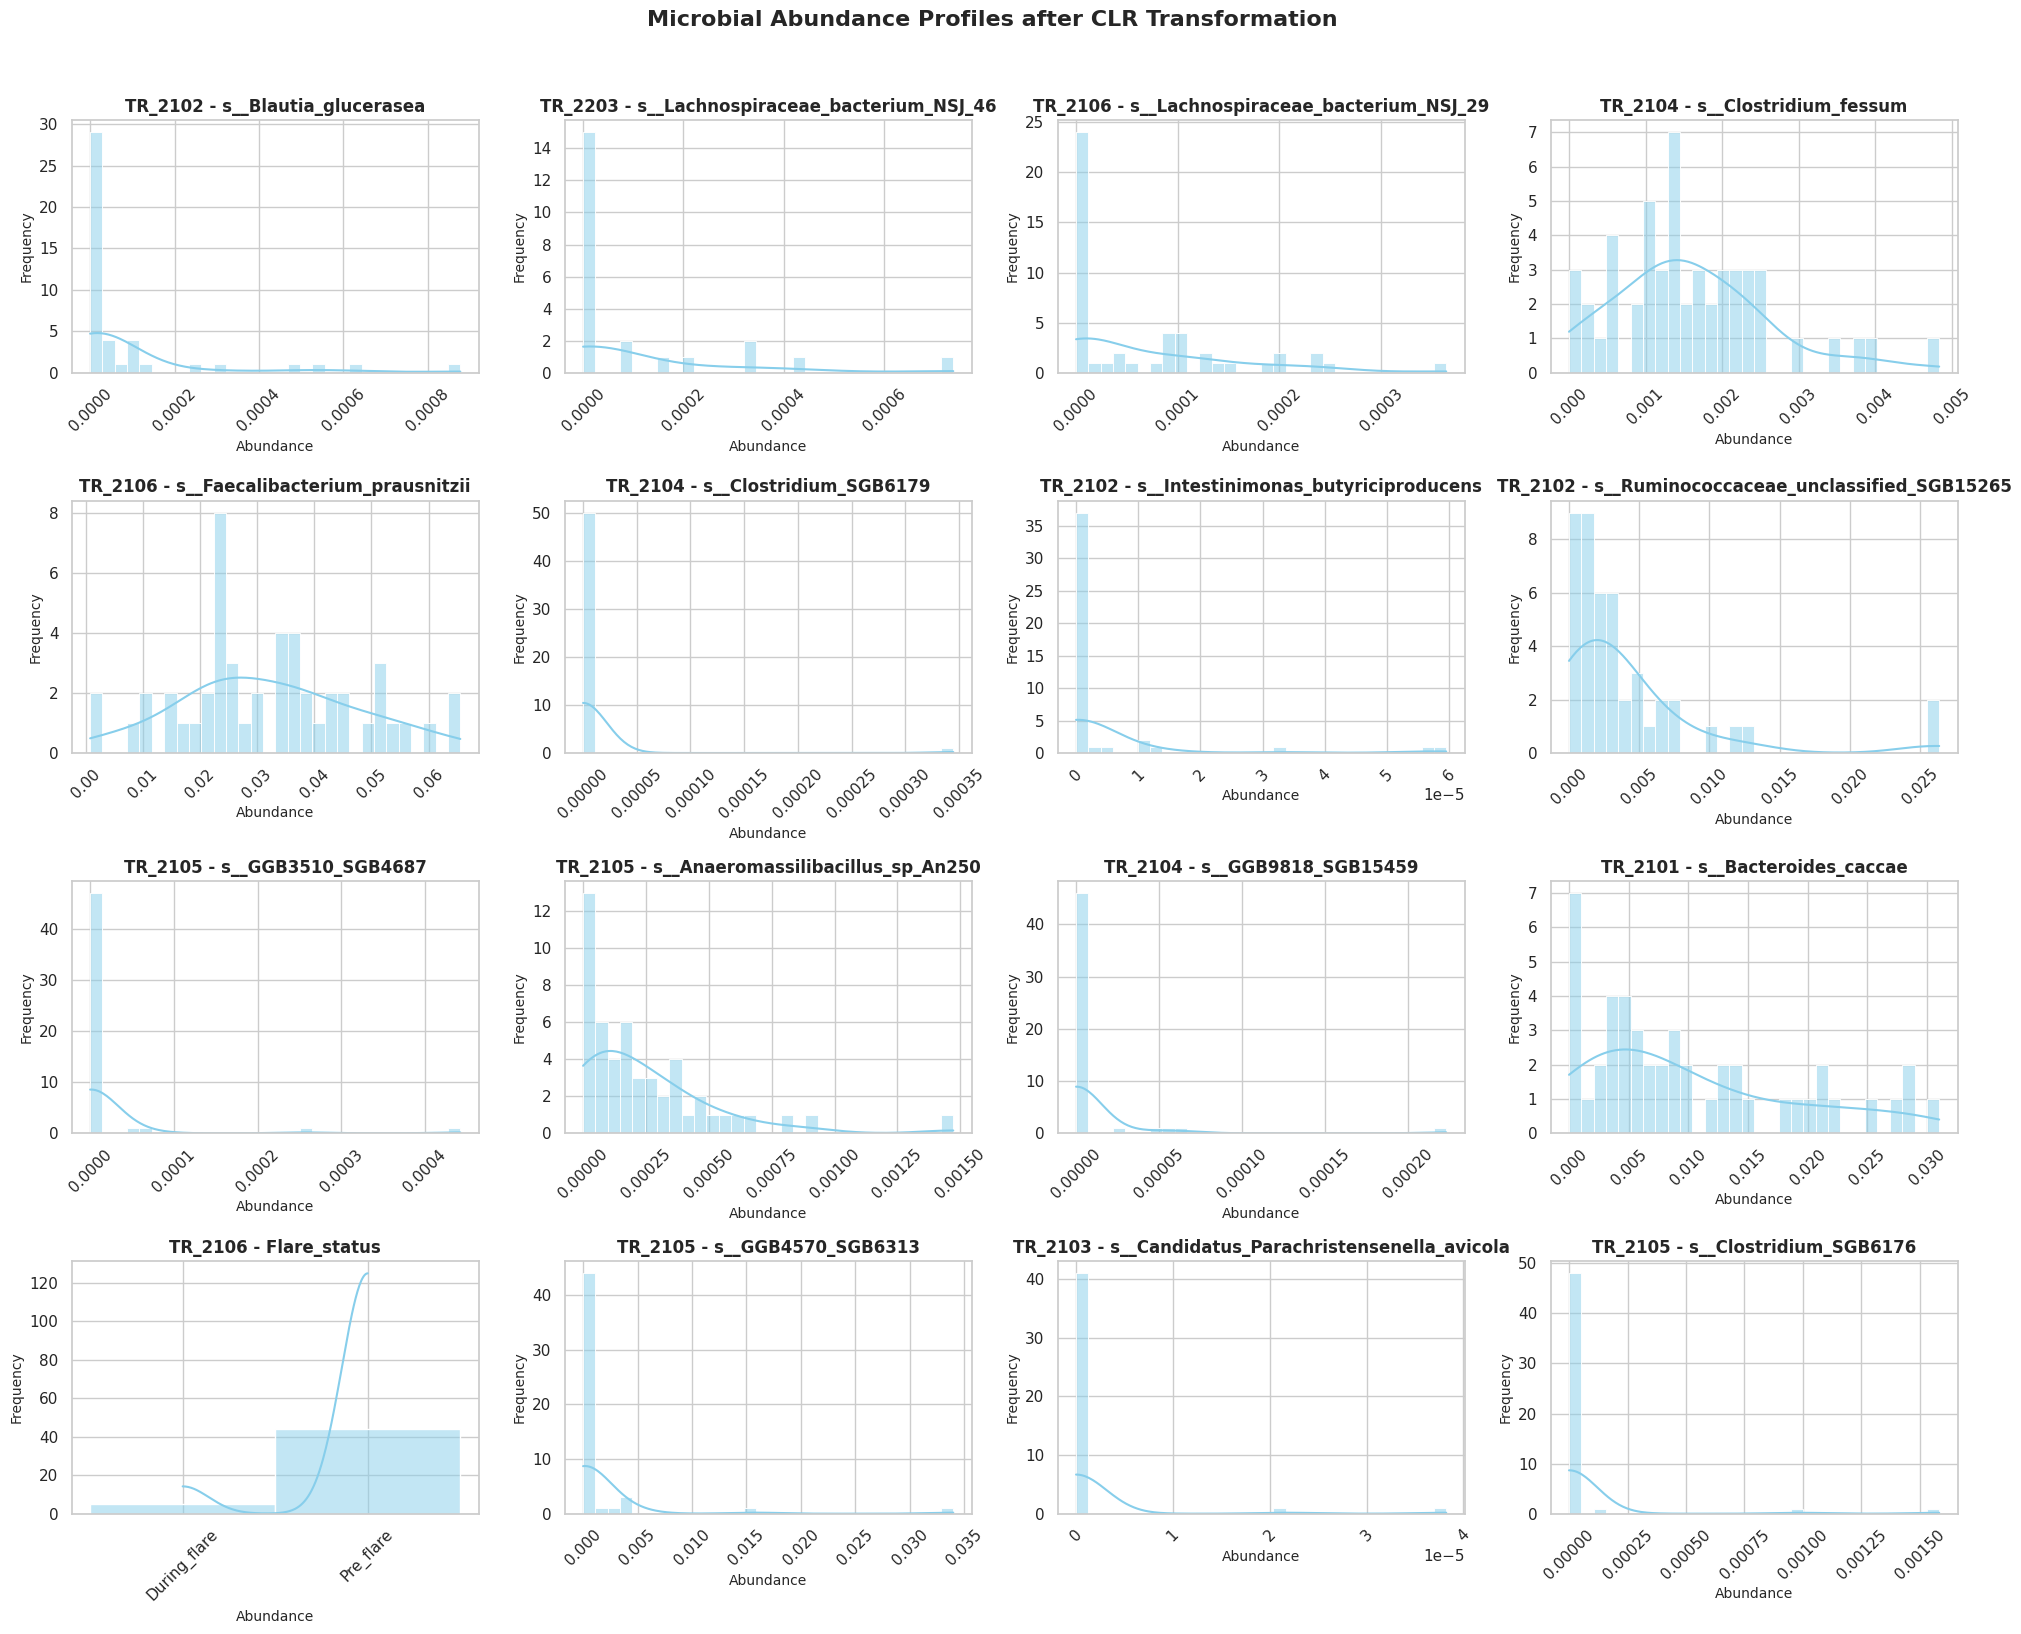

In [ ]:
# @title Plot Microbial Abundance Profiles
combinations = []

# Loop until we have 10 good combinations
while len(combinations) < 16:
    # Randomly select a patient_id and column name
    patient_id = metaphlan_df['patient_id'].sample().values[0]
    column_name = metaphlan_df.columns[np.random.randint(1, len(metaphlan_df.columns))]

    # Check if the values for the selected patient_id and column are not all zeros
    if not all(metaphlan_df[metaphlan_df['patient_id'] == patient_id][column_name] == 0):
        # Add the combination to the list
        combinations.append((patient_id, column_name))

# Print the list of good combinations
print(combinations)

# Define the number of rows and columns for the subplot grid
nrows = 4
ncols = 4

# Set the aesthetic style globally
sns.set(style="whitegrid")

# Create the figure and subplots with more space
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.4)  # Adjust horizontal and vertical spaces

# Iterate through the list of combinations
for i, (patient_id, column_name) in enumerate(combinations):
    ax = axes.flat[i]  # Select the current subplot

    # Plot the histogram of values with KDE
    sns.histplot(data=metaphlan_df[metaphlan_df['patient_id'] == patient_id][column_name],
                 ax=ax, bins=30, color='skyblue', kde=True)

    # Set the title and labels of the subplot
    ax.set_title(f'{patient_id} - {column_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Abundance', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)

    # Rotate x-axis labels for better readability if needed
    ax.tick_params(axis='x', rotation=45)

# Add a main title to the entire figure
fig.suptitle('Microbial Abundance Profiles after CLR Transformation',
             fontsize=16, fontweight='bold', y=1.02)

# Tight layout to utilize space better and prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
species_columns = [col for col in metaphlan_df.columns if col.startswith('s__')]
print(species_columns)
exclude_columns = metaphlan_df.columns.difference(species_columns)
gene_columns = gene_count_df.columns.difference(exclude_columns)

['s__GGB39918_SGB47522', 's__Actinobaculum_sp_oral_taxon_183', 's__Actinomyces_SGB17154', 's__Actinomyces_SGB17168', 's__Actinomyces_bouchesdurhonensis', 's__Actinomyces_dentalis', 's__Actinomyces_gerencseriae', 's__Actinomyces_graevenitzii', 's__Actinomyces_israelii', 's__Actinomyces_johnsonii', 's__Actinomyces_massiliensis', 's__Actinomyces_naeslundii', 's__Actinomyces_oris', 's__Actinomyces_sp_ICM47', 's__Actinomyces_sp_ICM58', 's__Actinomyces_sp_S6_Spd3', 's__Pauljensenia_hongkongensis', 's__Peptidiphaga_gingivicola', 's__Schaalia_turicensis', 's__Trueperella_pyogenes', 's__Alloscardovia_omnicolens', 's__Bifidobacterium_adolescentis', 's__Bifidobacterium_animalis', 's__Bifidobacterium_bifidum', 's__Bifidobacterium_breve', 's__Bifidobacterium_catenulatum', 's__Bifidobacterium_dentium', 's__Bifidobacterium_longum', 's__Bifidobacterium_pseudocatenulatum', 's__Bifidobacterium_pullorum', 's__Parascardovia_denticolens', 's__Scardovia_wiggsiae', 's__Corynebacterium_accolens', 's__Coryneba

In [ ]:
# @title align_flare_start_function
def align_flare_start_week(df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0):
    """
    Adjusts the week numbers for each patient in the dataframe such that the first occurrence
    of Flare_start=1 (that is not the first sample for the patient) occurs in the same target week for all patients who have a flare start.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    flare_column (str): Column name indicating the flare start.
    week_column (str): Column name indicating the week number.
    patient_column (str): Column name indicating the patient ID.
    target_week (int): The week number to which the first flare start should be aligned.

    Returns:
    pd.DataFrame: Modified DataFrame with adjusted week numbers.
    """
    df = df.copy()
    adjusted_dfs = []

    # Add a column indicating if the patient had a flare or not
    df['had_flare'] = df.groupby(patient_column)[flare_column].transform('max')

    for patient in df[patient_column].unique():
        patient_data = df[df[patient_column] == patient].copy()
        first_week = patient_data[week_column].min()

        if patient_data['had_flare'].iloc[0] == 1:
            # Identify flare weeks and remove the first week if it's a flare
            flare_weeks = patient_data[patient_data[flare_column] == 1][week_column]
            flare_weeks = flare_weeks[flare_weeks > first_week]  # ignore flare at the first recorded week

            if not flare_weeks.empty:
                flare_week = flare_weeks.min()  # first flare that's not at the first week
                shift = target_week - flare_week
                patient_data[week_column] += shift

        adjusted_dfs.append(patient_data)

    aligned_df = pd.concat(adjusted_dfs, ignore_index=True)

    # Normalize to ensure there are no negative weeks
    min_week = aligned_df[week_column].min()
    if min_week < 0:
       aligned_df.loc[aligned_df['had_flare'] == 1, week_column] -= min_week

    # Remove the temporary 'had_flare' column before returning
    aligned_df.drop('had_flare', axis=1, inplace=True)

    return aligned_df

In [ ]:
# @title assign_rbf
def assign_rbf(df, samples_before_flare, strict=False):
    # Initial setup
    df = df.sort_values(by=['patient_id', 'week'])
    df['RBF'] = 0  # Initialize the RBF column

    # Identify patients and all weeks where flares start
    flare_starts = df[df['Flare_start'] == 1].groupby('patient_id')['week'].apply(list)

    for patient, flare_weeks in flare_starts.items():
        # Handle each flare start week
        for flare_week in flare_weeks:
            # Get all weeks for the current patient
            patient_weeks = df.loc[df['patient_id'] == patient, 'week']

            if strict:
                # Find indexes for weeks strictly before this flare start and within the limit
                weeks_before_flare = patient_weeks[(patient_weeks < flare_week) & (patient_weeks >= flare_week - samples_before_flare)]
            else:
                # Find indexes for weeks before this flare start
                weeks_before_flare = patient_weeks[patient_weeks < flare_week].nlargest(samples_before_flare)


            # Set RBF to 1 for these weeks
            df.loc[(df['patient_id'] == patient) & (df['week'].isin(weeks_before_flare)), 'RBF'] = 1

    return df

In [ ]:
# @title plot_species_abundance_over_time_2 function
def plot_species_abundance_over_time_2(df, cols_to_plot, title, type_):
    """
    Plots the abundance over time for the specified species for all patients in the dataframe,
    with separate plots for patients with and without a flare start, all in a single figure with subplots.

    Args:
    df (pd.DataFrame): DataFrame containing microbial abundance data.
    cols_to_plot (list): List of species names to plot.
    title (str): Title for the plots and y-axis label.
    type_ (str): Label for the plot legend.
    """
    if not cols_to_plot:
        raise ValueError("cols_to_plot must be provided when selection_mode is 'user'")

    num_species = len(cols_to_plot)
    cols = 2  # Number of columns for subplots (one for with flare, one for without)
    rows = num_species  # Each species will occupy one row with two subplots

    fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))  # Adjust figsize as needed

    # If only one species, axs might not be a 2D array, ensure it is
    if num_species == 1:
        axs = [axs]

    # Determine patients where the first recorded week is a flare start
    df['first_week'] = df.groupby('patient_id')['week'].transform('min')  # Find first week for each patient
    first_flare_patients = df[(df['Flare_start'] == 1) & (df['week'] == df['first_week'])]['patient_id'].unique()
    patients_with_flare = df[(df['Flare_start'] == 1) & (~df['patient_id'].isin(first_flare_patients))]['patient_id'].unique()
    patients_without_flare = df[~df['patient_id'].isin(patients_with_flare)]['patient_id'].unique()


    for i, species in enumerate(cols_to_plot):
        # Plot for patients with flare
        ax = axs[i][0]

        for patient in patients_with_flare:
            patient_data = df[df['patient_id'] == patient].copy()
            patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

            if species in patient_data.columns:
                sns.lineplot(data=patient_data, x='week', y=species, ax=ax, label=f'Patient {patient}')

        # Annotate flare start changes
        flare_changes = df[(df["Flare_start"] == 1)&(df['patient_id'].isin(patients_with_flare ))][['week', 'Flare_start']].drop_duplicates()
        for _, (week, status) in flare_changes.iterrows():
            ax.axvline(x=week, color='grey', linestyle='--')
            ax.text(week, ax.get_ylim()[1], 'Flare_start', verticalalignment='top', fontsize=8)

        ax.set_title(f'{title} ({species}) Over Time for Patients with Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel(title)
        ax.legend(title=type_, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticks(df['week'].unique())
        ax.set_xticklabels(df['week'].unique(), rotation=45)

        # Plot for patients without flare
        ax = axs[i][1]
        for patient in patients_without_flare:
            patient_data = df[df['patient_id'] == patient].copy()
            patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

            if species in patient_data.columns:
                sns.lineplot(data=patient_data, x='week', y=species, ax=ax, label=f'Patient {patient}')

        ax.set_title(f'{title} ({species}) Over Time for Patients without Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel(title)
        ax.legend(title=type_, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticks(df['week'].unique())
        ax.set_xticklabels(df['week'].unique(), rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
# @title random forest based on first differences

def calculate_first_differences(df, cols_to_drop):
    """
    Calculates the first differences for each gene and species column, considering missing weeks and dummy patient_id columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing dummy 'patient_id' columns, 'week', 'Flare_status', 'RBF', and gene/species columns.

    Returns:
    pd.DataFrame: A new dataframe with the first differences and a week column.
    """
    # Identify patient_id columns
    patient_id_columns = [col for col in df.columns if col.startswith('patient_id')]

    # Identify gene/species columns
    exclude_columns = patient_id_columns + cols_to_drop
    gene_species_columns = df.columns.difference(exclude_columns)

    # Sort the dataframe by patient_id columns and week
    df = df.sort_values(by=patient_id_columns + ['week'])

    # Group by patient_id columns and calculate first differences
    df_diff = df.groupby(patient_id_columns).apply(lambda group: group[gene_species_columns].diff()).reset_index(drop=True)
    df.reset_index(drop=True, inplace=True)

    # Correct the week column in the first differences dataset
    df_diff['week'] = df['week']

    # Add patient_id columns back to the first differences dataset
    for col in patient_id_columns:
        df_diff[col] = df[col]

    # Add 'Flare_status' and 'RBF' columns back to the first differences dataset
    df_diff['Flare_status'] = df['Flare_status']
    df_diff['RBF'] = df['RBF']

    # Remove the first week for each patient as we cannot compute the difference for the first week
    df_diff.dropna(inplace=True, subset=gene_species_columns)

    # Reorder columns to match the original structure
    df_diff = df_diff[patient_id_columns + ['week'] + gene_species_columns.tolist() + ['Flare_status', 'RBF']]

    return df_diff

In [ ]:
print(gene_count_df.shape)
print(metaphlan_df.shape)

(605, 548)
(479, 1455)


In [ ]:
# #  @title  calculate aitchison distance for consecutive samples
# def calculate_aitchison_distance_consecutive(df, species_cols):
#     results = []

#     for patient in df['patient_id'].unique():
#         patient_data = df[df['patient_id'] == patient].copy()
#         patient_data = patient_data.sort_values(by='week')

#         for i in range(len(patient_data) - 1):
#             week_current = patient_data.iloc[i]['week']
#             week_next = patient_data.iloc[i + 1]['week']

#             clr_current = patient_data.iloc[i][species_cols]
#             clr_next = patient_data.iloc[i + 1][species_cols]

#             aitchison_dist = euclidean(clr_current, clr_next)
#             results.append({
#                 'patient_id': patient,
#                 'week_current': week_current,
#                 'week_next': week_next,
#                 'aitchison_distance': aitchison_dist,
#                 'Flare_start': patient_data.iloc[i]['Flare_start']
#             })

#     return pd.DataFrame(results)


# # Create a copy of the DataFrame to avoid modifying the original
# aitchison_df = metaphlan_df.copy()

# # Select columns with species data
# exclude_cols = ['patient_id', 'week', 'Flare_status',  'ts', 'RBF', 'ts_patient_id', 'PatientID_Weeknr']

# # Find the minimum positive value in the species data
# min_positive_value = aitchison_df[species_columns][aitchison_df[species_columns] > 0].min().min()

# # Replace zeros with the minimum positive value divided by two
# replacement_value = min_positive_value / 2
# aitchison_df[species_columns] = aitchison_df[species_columns].replace(0, replacement_value)


# to_plot_aitchison_df = calculate_aitchison_distance_consecutive(aitchison_df, species_columns)
# to_plot_aitchison_df.drop('week_current', axis= 1, inplace=True)
# to_plot_aitchison_df.rename(columns={'week_next': 'week'}, inplace=True)

In [ ]:
def clr_transform(df, metadata_columns):
    species_data = df.drop(columns=metadata_columns)
    species_data += 1e-5
    geometric_means = gmean(species_data, axis=1)
    clr_transformed_data = np.log(species_data.divide(geometric_means, axis=0))
    clr_transformed_df = pd.concat([df[metadata_columns], clr_transformed_data], axis=1)
    return clr_transformed_df

metaphlan_df = clr_transform(metaphlan_df, exclude_columns)

In [ ]:
gc = align_flare_start_week(gene_count_df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0)
mt = align_flare_start_week(metaphlan_df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0)

In [ ]:
week_stats = gene_count_df.groupby('patient_id')['week'].agg(['min', 'max'])
print(week_stats)

            min  max
patient_id          
TR_2101       1   52
TR_2102       1   53
TR_2103       1   52
TR_2104       1   52
TR_2105       1   52
TR_2106       0   52
TR_2107       0   52
TR_2108       0   52
TR_2201       1   52
TR_2202       1   50
TR_2203       0   52
TR_2204       0   52
TR_2205       1   50


In [ ]:
week_stats = metaphlan_df.groupby('patient_id')['week'].agg(['min', 'max'])
print(week_stats)

            min  max
patient_id          
TR_2101       1   52
TR_2102       1   53
TR_2103       1   52
TR_2104       1   52
TR_2105       1   52
TR_2106       0   52
TR_2107       0   42
TR_2108      16   52
TR_2201       1   52
TR_2202       1   50
TR_2203       0   22
TR_2205      39   50


# Classification

In [ ]:
cols_to_drop = [ 'week', 'Flare_status', 'RBF','PatientID_Weeknr']

In [ ]:
# @title Settings
samples_before_flare = 6
include_post_flare = False
strict= True
Normalize_to_Housekeeping = True
patient_ids = set(metaphlan_df['patient_id']) | set(gene_count_df['patient_id'])

In [ ]:
# @title Processing function
def processing(df, samples_before_flare, include_post_flare, include_during_flare=False, strict=False ):
  #Assign RBF flags with x samples before flare as default or any other number you wish
  print(f'samples before flare: {samples_before_flare}')
  df = assign_rbf(df, samples_before_flare=samples_before_flare, strict=strict)

  if not include_post_flare :
    data = df[(df["Flare_status"] != "Post_flare") &
               (df["Flare_status"] != "During_flare") &
               (df["Flare_status"] != "During_flare_2")]
  elif not include_during_flare :
    data = df[ (df["Flare_status"] != "During_flare") &
              (df["Flare_status"] != "During_flare_2")]

  else :
    data = df

  patient_cols= 'patient_id'
  #original_columns = set(data.columns)
  #data = pd.get_dummies(data, columns=['patient_id'], drop_first=True)
  #patient_cols = list(set(data.columns) - original_columns)


  print(data["RBF"].value_counts())
  return data, patient_cols

In [ ]:
# @title Hyperparameter tuning

def hyperparameter_tuning(data, cols_to_drop, patient_cols):
    # Drop specified columns and separate features and target
    X = data.drop(cols_to_drop + [patient_cols], axis=1)
    y = data['RBF']

    # Define the parameter grid
    param_grid = {
        'n_estimators': [12, 25, 100],  # Number of trees in the forest
        'max_features': ['log2', 'sqrt'],  # Number of features to consider at every split
        'max_depth': [None, 10, 30],   # Maximum number of levels in tree
        'min_samples_split': [2, 10, 15],   # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 3]      # Minimum number of samples required at each leaf node
    }

    # Initialize the Random Forest classifier
    clf = RandomForestClassifier(random_state=421)

    # Define scoring strategy
    scoring = 'f1'
    groups = data[patient_cols].values

    # Instantiate LeaveOneGroupOut
    logo = LeaveOneGroupOut()


    # Configure GridSearchCV to use the custom leave-one-out cross-validator
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=logo,
                                scoring=scoring, n_jobs=-1, verbose=5)

    grid_search.fit(X, y, groups=groups)  # Note the inclusion of the groups parameter here

    # Print the best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation recall score: {:.2f}".format(grid_search.best_score_))

    # Use the best estimator to make predictions
    best_clf = grid_search.best_estimator_

    importances = best_clf.feature_importances_
    # Get the index of importances from highest importance to lowest
    sorted_index = np.argsort(importances)[::-1]
    print("Feature ranking:")

    for idx in sorted_index:
        if importances[idx] > 0.01:
            print(f"{X.columns[idx]}: ({importances[idx]})")

    return grid_search

In [ ]:
# @title model evaluation
def model_evaluation(data, grid_search, cols_to_drop, patient_cols, settings, type, data_type='validation',  n_splits=10, result_file='/content/drive/MyDrive/MITResearch/IBD_13/evaluation_results_4.csv', print_details=False):
    """
    Evaluate the model using either training data or unseen data, computing a total confusion matrix from all splits.

    Parameters:
    data (pd.DataFrame): The dataframe containing the data.
    grid_search: The GridSearchCV object containing the trained model.
    cols_to_drop (list of str): The list of columns to drop.
    patient_cols (list of str): The list of dummy patient_id columns.
    data_type (str): The type of data to evaluate ('training' or 'validation'). Default is 'validation'.
    n_splits (int): Number of splits for cross-validation. Default is 10.

    Returns:
    None
    """
    # Data preparation
    data=data.sort_values(by = [patient_cols] + ['week'])
    X = data.drop(cols_to_drop +[ patient_cols], axis=1)
    y = data['RBF']

    # Assuming 'week' is a column in data
    weeks = data['week'] if 'week' in data.columns else None
    patient_ids = data[patient_cols]

    # Best model from GridSearchCV
    best_clf = grid_search.best_estimator_

    # Check if the 30th column starts with 's__'
    if data.shape[1] > 30:
      column_type = "Microbial Abundances" if data.columns[29].startswith('s__') else "Gene Expression"
    else :
      column_type = 'Alpha Diversity'

    logo = LeaveOneGroupOut()
    groups = data[patient_cols].values

    if data_type == 'validation':
        # Initialize the total confusion matrix
        total_confusion_matrix = np.zeros((2, 2))
        results = pd.DataFrame(columns=[patient_cols] + ['week', 'RBF', 'pred'])

        for train_index, test_index in logo.split(X, y, groups):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            weeks_test = weeks.iloc[test_index] if weeks is not None else None
            patient_ids_test = patient_ids.iloc[test_index] if patient_ids is not None else None

            # Fit the model
            best_clf.fit(X_train, y_train)
            y_pred = best_clf.predict(X_test)

            # Print predictions and true values if requested
            if print_details:
              results=pd.concat([results, pd.DataFrame({'patient_id': patient_ids_test, 'week': weeks_test, 'RBF': y_test,  'pred': y_pred})], ignore_index=True)

            # Compute confusion matrix for this fold
            cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

            # Sum up confusion matrices
            if total_confusion_matrix is None:
                total_confusion_matrix = cm
            else:
                total_confusion_matrix += cm


        # Print total confusion matrix from all folds
        print("\n Total Confusion Matrix from all folds:")
        print(total_confusion_matrix)

        if print_details:
          results.sort_values(by=['patient_id', 'week'], inplace=True)
          #results.reset_index(inplace=True)
          print(results[['patient_id','week','RBF','pred']])

        # Calculate recall from the total confusion matrix
        TP = total_confusion_matrix[1, 1]  # True Positives
        FN = total_confusion_matrix[1, 0]  # False Negatives
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0

        # Save the result to a CSV file
        result_data = {
        'Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Data_Type': data_type,
        'Confusion_Matrix': str(total_confusion_matrix.tolist()),
        'Parameters': str(grid_search.best_params_),
        'nsplits' : n_splits,
        'settings' : settings,
        'data': column_type,
        'type': type,
        'recall': recall
        }

        if not os.path.isfile(result_file):
            df = pd.DataFrame([result_data])
            df.to_csv(result_file, index=False)
        else:
            new_row = pd.DataFrame([result_data])
            df = pd.read_csv(result_file)
            df = pd.concat([df, new_row], ignore_index=True)
            df.to_csv(result_file, index=False)

        print("Results saved to:", result_file)

    elif data_type == 'training':
        # Fit the model
        best_clf.fit(X, y)

        # Predict on the training set
        y_pred = best_clf.predict(X)

        # Compute confusion matrix for the training set
        cm = confusion_matrix(y, y_pred)

        # Print the confusion matrix
        print("Training Set Confusion Matrix:")
        print(cm)

    else:
        raise ValueError("data_type must be 'training' or 'validation'")

In [ ]:
# metaphlan_df[['alpha_diversity_evenness', 'alpha_diversity_richness',
#        'alpha_diversity_shannon', 'alpha_diversity_simpson', 'common_species_with_last_week',
#        'count_above_0', 'count_above_0_01', 'count_above_0_03', 'count_above_0_05',
#        'count_above_0_1', 'count_above_0_3', 'dominant_species', 'dominant_species_2', 'log_Bwex']].describe()

In [ ]:
# metaphlan_df.drop(['alpha_diversity_evenness', 'alpha_diversity_richness',
#        'alpha_diversity_shannon', 'alpha_diversity_simpson', 'common_species_with_last_week',
#        'count_above_0', 'count_above_0_01', 'count_above_0_03', 'count_above_0_05',
#        'count_above_0_1', 'count_above_0_3', 'dominant_species', 'dominant_species_2', 'log_Bwex'], axis= 1, inplace= True)

In [ ]:
# # @title Microbial abundance modeling
settings= {'samples_before_flare': samples_before_flare, 'UCCD': 'not used', 'include_post_flare': include_post_flare, 'strict':strict, 'Normalize_to_Housekeeping' : Normalize_to_Housekeeping}
metaphlan, patient_cols  = processing(metaphlan_df, samples_before_flare=samples_before_flare, include_post_flare=include_post_flare, strict=strict)

grid_search = hyperparameter_tuning(metaphlan, cols_to_drop, patient_cols)

print("Best parameters:", grid_search.best_params_)
#model_evaluation(metaphlan, grid_search, cols_to_drop, patient_cols, settings,'raw', data_type='training', n_splits=10)
model_evaluation(metaphlan, grid_search, cols_to_drop, patient_cols, settings, 'raw', data_type='validation', n_splits=10, print_details=True)

samples before flare: 6
RBF
0    335
1     45
Name: count, dtype: int64
Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 12}
Best cross-validation recall score: 0.03
Feature ranking:
s__Peptoniphilus_senegalensis: (0.046808240029902914)
s__Parvimonas_micra: (0.0371566390256775)
s__GGB9469_SGB14863: (0.032884976781431915)
s__Blautia_sp_An81: (0.026362925397369796)
s__Bittarella_massiliensis: (0.024518957023212152)
s__Staphylococcus_SGB6340: (0.023203329674190393)
s__Bifidobacterium_pseudocatenulatum: (0.02208634598686803)
s__GGB2980_SGB3962: (0.021710150447533796)
s__Clostridium_SGB4909: (0.02109231119804113)
s__Lachnospiraceae_bacterium_Marseille_Q4251: (0.020615938821575197)
s__Peptostreptococcus_anaerobius: (0.018002226902667437)
s__Actinomyces_SGB17163: (0.017990313622403536)
s__Blautia_massiliensis: (0.017654866280258388)
s__Faecalibacterium_p

In [ ]:
# @title Gene Expression modeling
gene_count, patient_cols = processing(gene_count_df, samples_before_flare=samples_before_flare, include_post_flare=include_post_flare)

grid_search = hyperparameter_tuning(gene_count, cols_to_drop, patient_cols)

print("Best parameters:", grid_search.best_params_)
# model_evaluation(gene_count, grid_search, cols_to_drop, patient_cols, settings, 'raw', data_type='training', n_splits=10)
model_evaluation(gene_count, grid_search, cols_to_drop, patient_cols,  settings, 'raw',  data_type='validation', n_splits=10, print_details=True)

samples before flare: 6
RBF
0    404
1     55
Name: count, dtype: int64
Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 12}
Best cross-validation recall score: 0.09
Feature ranking:
OSM_ENSG00000099985_ENST00000215781: (0.03432943643067435)
NCF4_ENSG00000100365_ENST00000248899: (0.032518725337263445)
ATG16L2_ENSG00000168010_ENST00000321297: (0.027670777162352528)
CSF3R_ENSG00000119535_ENST00000373106: (0.02443438028577484)
AQP8_ENSG00000103375_ENST00000219660: (0.022300266799348)
NGFR_ENSG00000064300_ENST00000172229: (0.0205428524548556)
MUC2_ENSG00000198788_ENST00000675028: (0.01908744095300609)
SEL1L_ENSG00000071537_ENST00000336735: (0.017808893046690713)
CA2_ENSG00000104267_ENST00000285379: (0.014108044920968106)
CSF2RA_ENSG00000198223_ENST00000381524: (0.013289705744657376)
IL2RG_ENSG00000147168_ENST00000374202: (0.01172051944040574)
CEACAM6_ENS

don't use during flare and post flare samples
add patient id as a feature
ajouter les metadata dans le modele





In [ ]:
cols_to_drop =  [ 'week', 'Flare_status', 'RBF']

In [ ]:
metaphlan_df[['patient_id','week']].duplicated().sum()

0

In [ ]:
metaphlan_, patient_cols  = processing(metaphlan_df, samples_before_flare=samples_before_flare, include_post_flare=True, include_during_flare=True, strict=strict)
fd_metaphlan_df = calculate_first_differences(metaphlan_, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'])

fd_metaphlan_df= fd_metaphlan_df[ fd_metaphlan_df["Flare_status"] != "During_flare" ]

if not include_post_flare :
  fd_metaphlan_df= fd_metaphlan_df[ fd_metaphlan_df["Flare_status"] != "Post_flare" ]


grid_search = hyperparameter_tuning(fd_metaphlan_df,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

print("Best parameters:", grid_search.best_params_)
#model_evaluation(fd_metaphlan_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='training', n_splits=10)
model_evaluation(fd_metaphlan_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='validation', n_splits=10, print_details=True)

samples before flare: 6
RBF
0    432
1     47
Name: count, dtype: int64
Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 25}
Best cross-validation recall score: 0.02
Feature ranking:
s__Barnesiella_sp_An22: (0.01865759963321959)
s__Duodenibacillus_massiliensis: (0.016061698386971454)
s__Coprococcus_catus: (0.015924423434053737)
s__GGB3571_SGB4778: (0.015901310401951283)
s__GGB32387_SGB47381: (0.015855203250416915)
s__Alistipes_senegalensis: (0.014379832104024421)
s__GGB9580_SGB14996: (0.013937016797931944)
s__Collinsella_bouchesdurhonensis: (0.013471354696845367)
s__Butyricimonas_paravirosa: (0.012544223683943851)
s__GGB9734_SGB15304: (0.011386591650955296)
s__Limosilactobacillus_mucosae: (0.011181747019732978)
s__Anaerococcus_obesiensis: (0.011090279790257073)
s__Candidatus_Heritagella_gallinarum: (0.01097958733422947)
s__Peptostreptococcus_stoma

In [ ]:
gene_count_, patient_cols  = processing(gene_count_df, samples_before_flare=samples_before_flare, include_post_flare=True, include_during_flare=True, strict=strict)
fd_gene_count_df = calculate_first_differences(gene_count_, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'])

fd_gene_count_df= fd_gene_count_df[ fd_gene_count_df["Flare_status"] != "During_flare" ]

if not include_post_flare :
  fd_gene_count_df= fd_gene_count_df[ fd_gene_count_df["Flare_status"] != "Post_flare" ]


grid_search = hyperparameter_tuning(fd_gene_count_df,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

print("Best parameters:", grid_search.best_params_)
#model_evaluation(fd_gene_count_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='training', n_splits=10)
model_evaluation(fd_gene_count_df, grid_search, cols_to_drop, patient_cols, settings, 'first differences', data_type='validation', n_splits=10, print_details=True)

samples before flare: 6
RBF
0    550
1     55
Name: count, dtype: int64
Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 12}
Best cross-validation recall score: 0.05
Feature ranking:
IL17A_ENSG00000112115_ENST00000648244: (0.025186997337338035)
IL12RB1_ENSG00000096996_ENST00000600835: (0.02419222118973235)
TNFSF8_ENSG00000106952_ENST00000223795: (0.018187846851516136)
NCF4_ENSG00000100365_ENST00000248899: (0.014506591288730554)
PTPN22_ENSG00000134242_ENST00000359785: (0.013663008590174578)
TLR1_ENSG00000174125_ENST00000308979: (0.013510462621595882)
IL24_ENSG00000162892_ENST00000391929: (0.012318123503824066)
BCAR1_ENSG00000050820_ENST00000162330: (0.011063214228202672)
APC_ENSG00000134982_ENST00000257430: (0.01036188705771832)
IL11_ENSG00000095752_ENST00000264563: (0.010294847372002425)
Best parameters: {'max_depth': None, 'max_features': 'log2', 

Random Forest on deltas to base levels

In [ ]:
# @title Function to calculate base level differences

def calculate_base_level_differences(df, cols_to_drop, use_median=False):
    """
    Calculates the deviations from the base level (average or median) for each gene and species column, considering missing weeks and dummy patient_id columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing dummy 'patient_id' columns, 'week', 'Flare_status', 'RBF', and gene/species columns.
    use_median (bool): If True, use the median for the base level calculation. If False, use the mean.

    Returns:
    pd.DataFrame: A new dataframe with the base level deviations and preserved columns like 'week', 'Flare_status', and 'RBF'.
    """
    # Identify patient_id columns
    patient_id_columns = [col for col in df.columns if col.startswith('patient_id')]

    # Identify gene/species columns
    exclude_columns = patient_id_columns + cols_to_drop
    gene_species_columns = df.columns.difference(exclude_columns)

    # Sort the dataframe by patient_id columns and week
    df = df.sort_values(by=patient_id_columns + ['week'])

    # Group by patient_id columns and calculate the average or median
    if use_median:
        base_level = df.groupby(patient_id_columns)[gene_species_columns].transform('median')
    else:
        base_level = df.groupby(patient_id_columns)[gene_species_columns].transform('mean')

    # Calculate deviations from the base level
    df_base_level = df[gene_species_columns] - base_level

    # Create a subset of the original dataframe containing only the patient_id columns and other relevant columns
    additional_columns = df[patient_id_columns + ['week', 'Flare_status', 'RBF']]

    # Use pd.concat to add these columns to the df_base_level DataFrame along axis 1
    df_base_level = pd.concat([df_base_level, additional_columns], axis=1)


    # Reorder columns to match the original structure
    df_base_level = df_base_level[patient_id_columns + ['week'] + gene_species_columns.tolist() + ['Flare_status', 'RBF']]

    return df_base_level



In [ ]:
use_median = True
delta_metaphlan = calculate_base_level_differences(metaphlan, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr', 'Flare_start','patient_id'], use_median)
patient_cols= 'patient_id'

grid_search = hyperparameter_tuning(delta_metaphlan,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median'] = use_median
settings_

print("Best parameters:", grid_search.best_params_)
#model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='training', n_splits=10)
model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10, print_details=True)

Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 12}
Best cross-validation recall score: 0.05
Feature ranking:
s__GGB42689_SGB59892: (0.039042876196663495)
s__Clostridia_unclassified_SGB4121: (0.036530070669461116)
s__GGB32387_SGB47381: (0.03325865437340585)
s__Monoglobus_pectinilyticus: (0.03194417658679252)
s__GGB9621_SGB15073: (0.02841508313562931)
s__Parvimonas_micra: (0.02583847448415283)
s__Barnesiella_intestinihominis: (0.024269948381080486)
s__Peptostreptococcus_stomatis: (0.024228454738533255)
s__Actinomyces_bouchesdurhonensis: (0.02347074511520349)
s__Actinomyces_SGB17163: (0.021912422220842276)
s__Lachnospiraceae_bacterium_WCA3_601_WT_6H: (0.021374830485093255)
s__Eggerthella_sinensis: (0.02008001314780166)
s__GGB9524_SGB14924: (0.018361150795276053)
s__GGB9734_SGB15304: (0.017508845057982777)
s__GGB9707_SGB15229: (0.01727112631630297)


In [ ]:
use_median = True
delta_gene_count = calculate_base_level_differences(gene_count, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'], use_median)
patient_cols= 'patient_id'
grid_search = hyperparameter_tuning(delta_gene_count,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median']=use_median

print("Best parameters:", grid_search.best_params_)
#model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta' , data_type='training', n_splits=10)
model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10, print_details=True)

Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 12}
Best cross-validation recall score: 0.06
Feature ranking:
IL2RA_ENSG00000134460_ENST00000379959: (0.03205713579254551)
IFNA1_ENSG00000197919_ENST00000276927: (0.028556146203413995)
CD101_ENSG00000134256_ENST00000682167: (0.02394115838435033)
CD19_ENSG00000177455_ENST00000538922: (0.0221580344426377)
NLRP3_ENSG00000162711_ENST00000336119: (0.017923440657032243)
CLCF1_ENSG00000175505_ENST00000312438: (0.01778531678016581)
MKI67_ENSG00000148773_ENST00000368654: (0.016330685811794508)
IFNB1_ENSG00000171855_ENST00000380232: (0.015858402522093373)
CXCR4_ENSG00000121966_ENST00000241393: (0.015568314960687757)
C1GALT1C1_ENSG00000171155_ENST00000304661: (0.01524999504950913)
CCL5_ENSG00000271503_ENST00000603197: (0.013711991920034944)
TNFRSF4_ENSG00000186827_ENST00000379236: (0.013672674442264443)
TNFSF8_EN

In [ ]:
use_median = False
delta_metaphlan = calculate_base_level_differences(metaphlan, ['week', 'Flare_status', 'RBF', 'PatientID_Weeknr'], use_median)
patient_cols= 'patient_id'

grid_search = hyperparameter_tuning(delta_metaphlan,  ['week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median']=use_median

print("Best parameters:", grid_search.best_params_)
#model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='training', n_splits=10)
model_evaluation(delta_metaphlan, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10, print_details=True)

Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 12}
Best cross-validation recall score: 0.06
Feature ranking:
s__Peptostreptococcus_stomatis: (0.05423401538487262)
s__GGB9614_SGB15049: (0.050150657267299704)
s__Lactobacillus_delbrueckii: (0.021678664919244365)
s__Clostridiales_unclassified_SGB15148: (0.021439287010027175)
s__Finegoldia_magna: (0.020485893383264498)
s__Bacilli_unclassified_SGB6478: (0.018722743180316876)
s__Bifidobacterium_animalis: (0.017657681988807548)
s__Oscillibacter_sp_ER4: (0.016654278042601212)
s__Peptostreptococcus_anaerobius: (0.014484104088413316)
s__Hydrogenoanaerobacterium_saccharovorans: (0.014291822031060114)
s__GGB32387_SGB47381: (0.01373092113178182)
s__Alistipes_communis: (0.013368934380162588)
s__Intestinimonas_SGB15130: (0.013263232901369472)
s__Bilophila_wadsworthia: (0.013246777270724928)
s__Porphyromonas_SGB198

In [ ]:
use_median = False
delta_gene_count = calculate_base_level_differences(gene_count, [ 'week', 'Flare_status', 'RBF', 'PatientID_Weeknr'], use_median)
patient_cols= 'patient_id'
grid_search = hyperparameter_tuning(delta_gene_count,  [ 'week', 'Flare_status', 'RBF'], patient_cols)

settings_= settings.copy()
settings_['use_median']=use_median

print("Best parameters:", grid_search.best_params_)
#model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta' , data_type='training', n_splits=10)
model_evaluation(delta_gene_count, grid_search, cols_to_drop, patient_cols, settings_, 'delta', data_type='validation', n_splits=10)

Fitting 12 folds for each of 108 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 12}
Best cross-validation recall score: 0.05
Feature ranking:
MYC_ENSG00000136997_ENST00000621592: (0.037150532581453635)
CD19_ENSG00000177455_ENST00000538922: (0.020866585694066474)
IL17RB_ENSG00000056736_ENST00000288167: (0.019770557312136387)
CCR7_ENSG00000126353_ENST00000246657: (0.019596185916268518)
CLEC2D_ENSG00000069493_ENST00000290855: (0.019302416569216937)
ZAP70_ENSG00000115085_ENST00000264972: (0.016871327965529957)
IL12B_ENSG00000113302_ENST00000231228: (0.01570619228630751)
CXCL5_ENSG00000163735_ENST00000296027: (0.014015627546817655)
NLRP3_ENSG00000162711_ENST00000336119: (0.013945578231292529)
C1GALT1C1_ENSG00000171155_ENST00000304661: (0.013306327026502168)
NCF4_ENSG00000100365_ENST00000248899: (0.012761017012868595)
CD4_ENSG00000010610_ENST00000011653: (0.012247116077133241)
HNRNPA1

# **TEST**

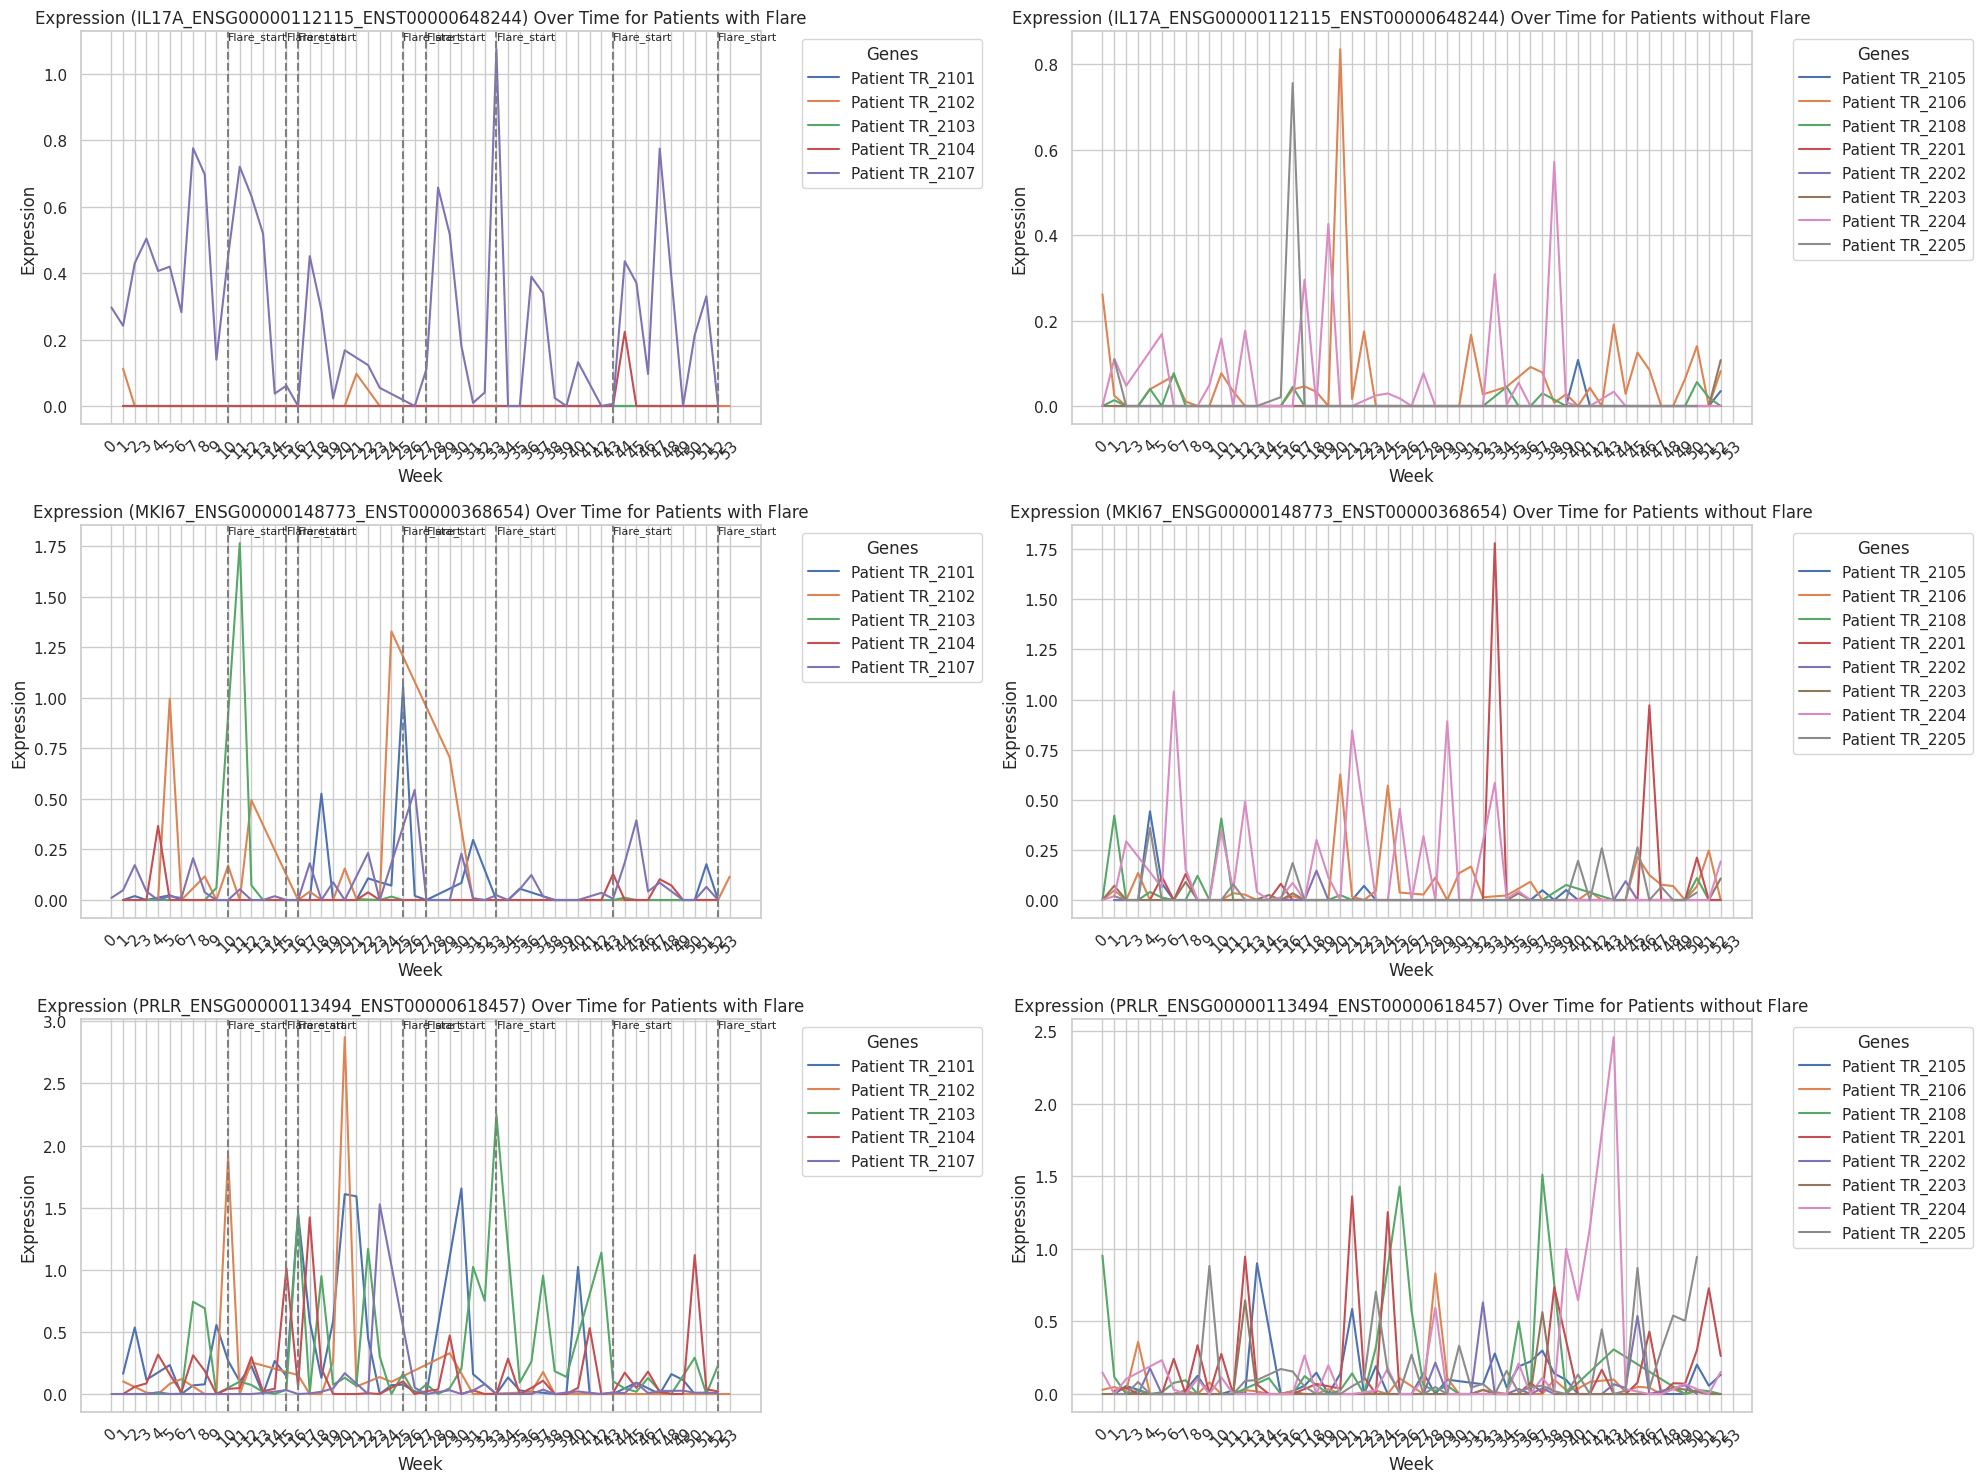

In [ ]:
# @ title species to investigate
plot_species_abundance_over_time_2(gene_count_df,   ['IL17A_ENSG00000112115_ENST00000648244', 'MKI67_ENSG00000148773_ENST00000368654', 'PRLR_ENSG00000113494_ENST00000618457'], 'Expression', 'Genes')

In [ ]:
# @title calculate_alpha_diversity function

def calculate_alpha_diversity(df, diversity_index='shannon'):
    """Calculate alpha diversity based on the specified diversity index."""
    if diversity_index == 'shannon':
        return df.apply(lambda x: entropy(x[x > 0]), axis=1)
    elif diversity_index == 'simpson':
        def simpson_index(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            p = x / x.sum()
            return 1 - np.sum(p**2)
        return df.apply(simpson_index, axis=1)
    elif diversity_index == 'richness':
        return df.apply(lambda x: (x > 0).sum(), axis=1)
    elif diversity_index == 'evenness':
        # Calculate evenness using Pielou's evenness index
        def pielou_evenness(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            shannon = entropy(x)
            richness = np.log(len(x))
            if richness == 0:
                return np.nan  # Avoid division by zero
            return shannon / richness
        return df.apply(pielou_evenness, axis=1)
    else:
        raise ValueError("Unsupported diversity index specified.")


In [ ]:
# diversity_indices = ['richness']
# alpha_div = metaphlan_df[['patient_id', 'week', 'Flare_status', 'Flare_start']].copy()

# # Calculate all types of alpha diversities
# for index in diversity_indices:
#     alpha_div[f'alpha_diversity_{index}'] = calculate_alpha_diversity(
#         metaphlan_df[species_columns], index)

In [ ]:
# samples_before_flare = 8

In [ ]:
# # # @title Microbial abundance modeling
# settings= {'samples_before_flare': samples_before_flare, 'UCCD': 'not used', 'include_post_flare': False, 'strict':True, 'Normalize_to_Housekeeping' : Normalize_to_Housekeeping}
# alpha, patient_cols  = processing(alpha_div, samples_before_flare=samples_before_flare, include_post_flare=include_post_flare, strict=strict)

# grid_search = hyperparameter_tuning(alpha, cols_to_drop, patient_cols)

In [ ]:
# print("Best parameters:", grid_search.best_params_)
# #model_evaluation(metaphlan, grid_search, cols_to_drop, patient_cols, settings,'raw', data_type='training', n_splits=10)
# model_evaluation(alpha, grid_search, cols_to_drop, patient_cols, settings, 'raw', data_type='validation', n_splits=10, print_details=True)